*Copyright (c) 2023 Graphcore Ltd. All rights reserved.*

$$
\renewcommand{\br}{\mathbf{r}}
\renewcommand{\bA}{\mathbf{A}}
$$

# Integrals over Gaussian Type Orbitals (GTO)

Zooming straight past a number of details, a standard approach in density functional theory (DFT)
is to expand the molecular orbitals $\{\psi_i (\br) \}$ in a finite basis set:
$$
\tag{1}
\psi_i (\br) = \sum_i^N c_i \phi_i (\br).
$$
Typically the basis functions $\{\phi_i (\br) \}$ are taken as approximations of atomic orbitals and this is referred to as the linear combination of atomic orbitals (LCAO) method in the literature. There is some flexibility in how exactly this finite
basis is defined.  Gaussian type orbitals (GTO) are perhaps
one of the most popular choices and take the following general form 
$$
\tag{2}
\phi_i (\br; \bA, \alpha, l, m, n) = N x_A^l y_A^m z_A^n e^{-\alpha |\br - \bA|^2}.
$$
These functions are parameterised by:
* $\bA = (X_A, Y_A, Z_A)$ is the center of the Gaussian orbital that for our current treatment will be set by the atomic positions of the molecular structure we are simulating. We use the common shorthand of $x_A = x - X_A$ in the leading polynomial term
* $\alpha$ in the exponent determines the extent of the Gaussian orbital.
* $(l, m, n)$ are the angular momentum quantum numbers that take on non-negative integer values.
* normalising constant $N$ is a function of $\alpha$ and $(l, m, n)$ and is derived later in this notebook.

Another complication that is worth mentioning up front is that we typically encounter 
*contracted* Gaussian basis functions defined as:
$$
\tag{3}
\phi_i (\br; \bA, l, m, n)  = \sum_\mu^L d_{\mu i} p_\mu(\br; \bA, \alpha_\mu, l, m, n)
$$
where we introduce the *primitive* Gaussian $p_\mu$ that take the form:
$$
p_\mu(\br; \bA, \alpha_\mu, l, m, n) = N x_A^l y_A^m z_A^n e^{-\alpha_\mu |\br - \bA|^2}.
$$
Gaussian basis functions of the form above have a few convenient properties that help
make it easier to evaluate the matrices comprised of molecular elements.

It can be useful for view DFT an optimisation problem where we search for the expansion coefficients that minimise the total energy.  There are additional constraints such as maintaining orthonormality between the molecular orbitals
maintaining orthonormality in the molecular orbitals. 

For an overview and derivation we refer the reader to the following review article:

> Lehtola, S., Blockhuys, F. and Van Alsenoy, C., 2020. An overview of self-consistent field calculations within finite basis sets. Molecules, 25(5), p.1218. [open access](https://doi.org/10.3390/molecules25051218)



In [ ]:
import numpy as np
import IPython
from sympy import *

init_printing(use_unicode=True)

# Primitive GTO

The unnormalized Cartesian GTO (Gaussian-type Orbital) primitive is defined as follows:
\begin{align*}
\hat p(\mathbf{r}; l,m,n, \alpha) =
 p(\mathbf r; \nu) = ~ &  x^l y^m z^n e^{-\alpha |\mathbf{r}|^2} \\
& \text{where} ~ \mathbf{r} = (x, y, z) ~ \text{and} ~ \nu = (l, m, n, \alpha)
\end{align*}

From which the normalized primitive is
\begin{align*}
p(\mathbf{r}; \nu) = & \frac 1 {Z_\nu} ~ \hat p(\mathbf{r}; \nu)
\end{align*}
where the normalizing constant $Z_\nu$ is defined so that
$$
\int_{-\infty}^\infty p(\mathbf r; \nu)^2 \mathrm{d}\mathbf r = 1,
$$
that is:
\begin{aligned}
Z_\nu^2  = \int \hat p(\mathbf{r}; \nu)^2 d\mathbf{r}
\end{aligned}

So, squaring all terms in the integrand:
\begin{aligned}
Z_\nu^2 & = \iiint x^{2l} y^{2m} z^{2n} e^{-2\alpha (x^2 + y^2 + z^2)} \text{d}z \text{d}y \text{d}x\\
 & = \iiint x^{2l} y^{2m} z^{2n} e^{-2\alpha x^2}e^{-2\alpha y^2}e^{-2\alpha z^2} \text{d}z \text{d}y \text{d}x\\
 & = \iiint x^{2l} e^{-2\alpha x^2} y^{2m} e^{-2\alpha y^2} z^{2n} e^{-2\alpha z^2} \text{d}z \text{d}y \text{d}x\\
 & = \int x^{2l} e^{-2\alpha x^2} \int y^{2m} e^{-2\alpha y^2} \int z^{2n} e^{-2\alpha z^2} \text{d}z \text{d}y \text{d}x\\
 & = \int x^{2l} e^{-2\alpha x^2} \text{d}x 
     \int y^{2m} e^{-2\alpha y^2} \text{d}y
     \int z^{2n} e^{-2\alpha z^2} \text{d}z\\
 & = ZZ(l,\alpha) ZZ(m,\alpha) ZZ(n,\alpha)
\end{aligned}
where 
$$
ZZ(k, a) = \int_{-\infty}^{\infty} t^{2k} e^{- 2 a t^2} dt
$$


In [ ]:
a = Symbol("alpha", positive=True, real=True)
k = Symbol("k", integer=True, nonnegative=True)
t, x, y, z = symbols("t x y z", real=True)

ZZ = Integral(t**(2*k) * exp(-2 * a * t**2), (t, -oo, oo))
IPython.display.Math(r'ZZ(k,\alpha) = ' + latex(ZZ) + ' = ' + latex(simplify(ZZ.doit())))

<IPython.core.display.Math object>

In [ ]:
l,m,n,L = symbols("l m n L", integer=True, nonnegative=True)
Z2 = (ZZ.subs(k, l) * ZZ.subs(k, m) * ZZ.subs(k, n))
Z2_expanded = simplify(Z2.doit()).subs(l+m+n, L)
IPython.display.Math(r'Z^2(l,m,n,\alpha) = ' + latex(Z2) + ' \quad = \quad \Large ' + latex(Z2_expanded))

<IPython.core.display.Math object>

In [ ]:
f = lambdify((l,m,n, a), Z2_expanded, modules="scipy")
help(f)

Help on function _lambdifygenerated:

_lambdifygenerated(l, m, n, alpha)
    Created with lambdify. Signature:
    
    func(l, m, n, alpha)
    
    Expression:
    
    (1/(2*alpha))**(L + 3/2)*gamma(l + 1/2)*gamma(m + 1/2)*gamma(n + 1/2)
    
    Source code:
    
    def _lambdifygenerated(l, m, n, alpha):
        return ((1/2)/alpha)**(L + 3/2)*gamma(l + 1/2)*gamma(m + 1/2)*gamma(n + 1/2)
    
    
    Imported modules:



In [ ]:
z000 = sqrt(Z2).subs(((l,0), (m,0), (n,0))).doit()
IPython.display.Math(r'\Large{' + latex(Symbol('z000')) + '= ' + latex(z000) + '}')

<IPython.core.display.Math object>

In [ ]:
out= r'\begin{align*}~'
for vl,vm,vn in ((0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(0,1,1),(1,1,1),(2,0,0),(2,2,0)):
  zllm = sqrt(Z2).subs(((l,vl), (m,vm), (n,vn))).doit() / z000 * Symbol('z_000')
  out += r'\\' + latex(Symbol(f'z{vl}{vm}{vn}')) + '= ' + latex(zllm)
out += r'\end{align*}'
IPython.display.Latex(out)

<IPython.core.display.Latex object>

# From factorial

In [ ]:
import scipy
p = Symbol('p', integer=True)

# n!! = special.gamma(n/2+1)*2**((m+1)/2)/sqrt(pi)  n odd
#     = 2**(n/2) * (n/2)!                           n even

def fac2(n):
  assert n % 2 == 1
  return gamma(n/2+1)*2**((n+1)/2)/sqrt(pi) # n odd


for n in (-1,1,3,5,13,23):
  v1 = scipy.special.factorial2(n)
  v2 = float(fac2(n).evalf())
  print(v1, v2)
  assert np.isclose(v1, v2)


1.0 1.0
1.0 1.0
3.0000000000000004 3.0
15.000000000000004 15.0
135135.00000000003 135135.0
316234143225.00006 316234143225.0


In [ ]:
l,m,n = symbols("l m n", integer=True, nonnegative=True)
alpha = Symbol("alpha", positive=True, real=True)

def current_squared(l,m,n):
  L = l+m+n
  N = pi**1.5 / (2 * alpha) ** (L + 1.5)
  N *= fac2(2*l-1) * fac2(2*m-1) * fac2(2*n-1) / 2**L
  return N

def gammabased(l,m,n):
  def fac2pm1(p):
    return fac2(2*p-1)
  
  L = l+m+n
  N = pi**1.5 / (2 * alpha) ** (L + 1.5)
  N *= fac2pm1(l) * fac2pm1(m) * fac2pm1(n) / 2**L
  return N


display(current_squared(l,m,n).simplify(), Z2_expanded)

# Next steps

And now, evaluate over the range $(0,1)$ rather than $(-\infty,\infty)$:

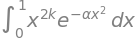

In [ ]:
ZZ01 = Integral(x ** (2 * k) * exp(-a * x**2), (x, 0, 1))
ZZ01_expanded = simplify(ZZ01.doit())
display(ZZ01, ZZ01_expanded)